# import

In [1]:

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from my_library.library import *
from pprint import pprint
import json
import requests
import sys
path_ =  '/Users/Owner/Desktop/coincheck_api'
sys.path.append(path_)
from settings_coincheck import API_settings as capi
import ccxt
import datetime
import logging
from pprint import pprint
import json
import requests
import time
from logging import getLogger,Formatter, StreamHandler, FileHandler, DEBUG, INFO
import math

# API KEY

In [2]:

API_KEY = capi.API_KEY
API_SECRET = capi.API_SECRET
coincheck = ccxt.coincheck({'apiKey':API_KEY,'secret':API_SECRET})


# 定数

In [142]:
# 交換する通貨のペア
SYMBOL = "BTC/JPY"

# 最適指値の計算に用いる, 注文数量の閾値
SIZE_THRU = 0.05

# 取引するBTCの数量
# 今回はcoincheckの最小取引数量とした
BTC_AMOUNT = 0.005

# スプレッドの閾値
ALPHA = 0.00045

# 変化率 (下落率) の閾値
# 下落変化率の大きい相場では取引しない
PCT_RATE = -0.01

# 指値更新の値幅, 2円ずつ更新
DP = 4

# 最適指値で約定しなかった際, 1円の利益で妥協するための差分
DELTA = 400

# ローソク足の時間間隔
MIN_WIDTH = '15m'

# 何分約定しなかったら損切スタートさせるか決める定数
LOOP_COUNT = 450

# LINE notify のapi利用に必要なトークン
TOKEN = 'Iv1JfBTaTgdYr1ganO9xf2FAGZHQDUXFa0xBJuMHlJm'



# funcs

In [155]:



#　取引通貨情報
def market_info():
    result = coincheck.load_markets()
    return result

# 板情報を取得する関数
def OrderBook():
    result = coincheck.fetchOrderBook(symbol=SYMBOL)
    return result

# 売り注文と買い注文を取得する関数
def ticker_info():
    result = coincheck.fetch_ticker(symbol=SYMBOL)
    return result

# 口座情報を取得する関数
def balance_info():
    result = coincheck.fetchBalance()
    return result

# 今出している注文をキャンセルする関数
# order_id は OpenOrder関数から取得可能
def OrderCancel(order_id):
    result = coincheck.cancel_order(
                    symbol = SYMBOL,  # 取引通貨
                    id = order_id,    # 注文ID
                    )
    return result

# 今出している注文を取得する関数
def OpenOrder():
    result = coincheck.fetchOpenOrders(symbol = SYMBOL)
    return result

# 買い注文を出す関数
def buy(price_value, btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'buy'       # 買い(buy) or 売り(sell)


    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order

# 売り注文を出す関数
def sell(price_value,btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'sell'       # 買い(buy) or 売り(sell)


    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order
    
# 買い注文, 売り注文が約定したかどうか把握する関数
# is_buy : True -> 買い注文約定
# is_sell : True -> 売り注文約定
def get_status(sell_amount):
    symbol = 'BTC/JPY'
    order_now = OpenOrder()
    b_info = balance_info()
    free = float(b_info['free']['BTC'])
    used = float(b_info['used']['BTC'])
    total = float(b_info['total']['BTC'])
    
    is_buy = False
    is_sell = False    
    # if len(order_now)==0 and used==0 and free>=BTC_AMOUNT:
    #     is_buy = True
    #     is_sell = True
    # freeがBTC_AMOUT以下になる　つまり, 一部しか約定しない時があるならば, usedも0にならない時があるのでは?
    if len(order_now)==0 and used==0 and free>0:
        is_buy = True
        is_sell = True

    elif len(order_now)==1 :
        side = order_now[0]['side']
        if side == 'buy':
            is_sell = True
        elif side == 'sell':
            is_buy = True
    elif len(order_now)==2 and used==sell_amount and free==0:
        pass
    elif len(order_now)==2:
        side0 = order_now[0]['side']
        side1 = order_now[1]['side']
        
        if side0==side1=='buy' or side0==side1=='sell':
            # 古いほうの買い注文キャンセルしたい
            # 0 が古いほう
            if side0=='buy':logger.info('Two buy order')
            if side0=='sell':logger.info('Two sell order')
            
            old_order = order_now[0]['id']
            try:
                order_cancel = OrderCancel(old_order)
            except Exception as e:
                logger.info(e)
                logger.info('Cant cancel in get_status')
        
        else:
            logger.info('Buy and Sell order')
            logger.info('free {0}'.format(free))
            logger.info('used {0}'.format(used))
    else:
        logger.info('default')
        logger.info('free {0}'.format(free))
        logger.info('used {0}'.format(used))
        logger.info('order length :{0}'.format(len(order_now)))
        time.sleep(1)
        
    return is_buy, is_sell

# logを表示する関数
def show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=0.005):
    sell = math.floor(sell_price*btc_amount)
    buy = math.ceil(buy_price*btc_amount)
    profit = sell - buy
    b_info = balance_info()
    remain_btc = float(b_info['info']['btc'])
    logger.info("-------------------")
    logger.info('Done trade')
    logger.info('sell price  :{0}'.format(int(sell_price)))
    logger.info('buy price   :{0}'.format(int(buy_price)))
    logger.info('profit      :{0}'.format(profit))
    logger.info('trade_count :{0}'.format(trade_count))
    logger.info('free        :{0}'.format(b_info['free']['BTC']))
    logger.info('used        :{0}'.format(b_info['used']['BTC']))
    logger.info('total       :{0}'.format(b_info['total']['BTC']))
    logger.info('Total profit:{0}'.format(total_profit+profit))
    logger.info('spread      :{0}'.format(spread))
    logger.info("-------------------")
    
    return profit, remain_btc



# 板情報から最適な指値を計算する関数
def calc_best_price(size_thru=0.05):
    orderbook = OrderBook()
    ask_list = orderbook['asks']
    bid_list = orderbook['bids']

    i = 0
    b_amount = 0
    while b_amount<=size_thru:
        b_amount += bid_list[i][1]
        buy_price = bid_list[i][0]
        i+=1
        

    i=0
    a_amount = 0
    while a_amount<=size_thru:
        a_amount += ask_list[i][1]
        sell_price = ask_list[i][0]
        i+=1
        
    ask = ask_list[0][0]
    bid = bid_list[0][0]
    
    return ask,bid,buy_price,sell_price

# ローソク足を取得する関数
def return_candles(min_='15m'):
    candles = coincheck.fetch_ohlcv(
        symbol=SYMBOL,     # 暗号資産[通貨]
        timeframe = min_,    # 時間足('1m', '5m', '1h', '1d')
        since=None,           # 取得開始時刻(Unix Timeミリ秒)
        limit=None,           # 取得件数(デフォルト:100、最大:500)
        params={}             # 各種パラメータ
        )
    return candles

# ローソク足からボラティリティを計算する関数
def calc_pct_rate(candles):
    open_ = candles[0][1]
    high_ = candles[0][2]
    low_ = candles[0][3]
    close_ = candles[0][4]
    
    pct_rate = (close_-open_)/open_
    return pct_rate

# LINE に通知する関数
def send_line_notify(message):
    """
    LINEに通知する
    """
    line_notify_token = TOKEN
    line_notify_api = 'https://notify-api.line.me/api/notify'
    headers = {'Authorization': f'Bearer {line_notify_token}'}
    data = {'message': f'message: {message}'}
    requests.post(line_notify_api, headers = headers, data = data)
    

# ある時刻における ask 注文密度　
横軸価格差　※差分は１ずつではない\
縦軸注文量

In [114]:
def Yakujo(symbol):
    result = coincheck.fetchMyTrades(symbol = symbol)
    return result

# 引数情報
symbol = 'BTC/JPY'

# 出力
pprint(Yakujo(symbol))

[]


In [116]:
coincheck.fetch_trades(symbol)

[{'id': '230908893',
  'info': {'id': '230908893',
   'amount': '0.01751638',
   'rate': '2717933.0',
   'pair': 'btc_jpy',
   'order_type': 'buy',
   'created_at': '2022-09-21T08:24:23.000Z'},
  'datetime': '2022-09-21T08:24:23.000Z',
  'timestamp': 1663748663000,
  'symbol': 'BTC/JPY',
  'type': None,
  'side': 'buy',
  'order': None,
  'takerOrMaker': None,
  'price': 2717933.0,
  'amount': 0.01751638,
  'cost': 47608.34724254,
  'fee': None,
  'fees': []},
 {'id': '230908894',
  'info': {'id': '230908894',
   'amount': '0.03248362',
   'rate': '2718000.0',
   'pair': 'btc_jpy',
   'order_type': 'buy',
   'created_at': '2022-09-21T08:24:23.000Z'},
  'datetime': '2022-09-21T08:24:23.000Z',
  'timestamp': 1663748663000,
  'symbol': 'BTC/JPY',
  'type': None,
  'side': 'buy',
  'order': None,
  'takerOrMaker': None,
  'price': 2718000.0,
  'amount': 0.03248362,
  'cost': 88290.47916,
  'fee': None,
  'fees': []},
 {'id': '230908895',
  'info': {'id': '230908895',
   'amount': '0.006',


In [32]:
from scipy import signal

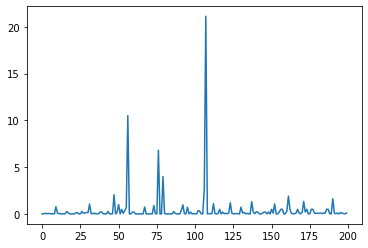

In [33]:
# ask_list[row][col] col = 0 => price, col = 1 => vol

ask_array = np.array(ask_list)
ask_env = np.abs(signal.hilbert(ask_array[:,1]))
plt.plot(ask_array[:,1])
# plt.plot(ask_env[:50])

# 単発買い注文

In [125]:

symbol = 'BTC/JPY'
board = ticker_info()
buy_price = board['bid'] + 1
buy_price

2752529.0

In [128]:
symbol = 'BTC/JPY'
board = ticker_info()

buy_price = board['bid'] + 1
sell_price = board['ask'] - 1

order_buy = buy(2552529)

# 単発売り注文

In [104]:
symbol = 'BTC/JPY'
board = ticker_info()

buy_price = board['bid'] + 1
sell_price = 2790000

btc_amount = 0.005
order_sell = sell(sell_price,btc_amount=0.005)

In [106]:
OpenOrder()

[]

# やばい時の変化率
+ の変化率は無視, - の変化率の時だけひっこめる

In [40]:
h = 2874
l = 2844
(h-l)/l

0.010548523206751054

In [90]:
symbol = 'BTC/JPY'
order_now = OpenOrder()

order_now


[]

# order cancel

In [135]:
OpenOrder()

[]

In [134]:
# order_id = order_buy['id']
order_cancel = OrderCancel(5009873925)

In [139]:
balance_info(
)

{'info': {'success': True,
  'jpy': '34801.00165126',
  'btc': '0.005',
  'eth': '0.0',
  'etc': '0.0',
  'lsk': '0.0',
  'xrp': '0.0',
  'xem': '0.0',
  'ltc': '0.0',
  'bch': '0.0',
  'mona': '0.0',
  'xlm': '0.0',
  'qtum': '0.0',
  'bat': '0.0',
  'iost': '0.0',
  'enj': '0.0',
  'omg': '0.0',
  'plt': '0.0',
  'sand': '0.0',
  'xym': '0.0',
  'dot': '0.0',
  'jpy_reserved': '0.0',
  'btc_reserved': '0.0',
  'eth_reserved': '0.0',
  'etc_reserved': '0.0',
  'lsk_reserved': '0.0',
  'xrp_reserved': '0.0',
  'xem_reserved': '0.0',
  'ltc_reserved': '0.0',
  'bch_reserved': '0.0',
  'mona_reserved': '0.0',
  'xlm_reserved': '0.0',
  'qtum_reserved': '0.0',
  'bat_reserved': '0.0',
  'iost_reserved': '0.0',
  'enj_reserved': '0.0',
  'omg_reserved': '0.0',
  'plt_reserved': '0.0',
  'sand_reserved': '0.0',
  'xym_reserved': '0.0',
  'dot_reserved': '0.0',
  'jpy_lend_in_use': '0.0',
  'btc_lend_in_use': '0.0',
  'eth_lend_in_use': '0.0',
  'etc_lend_in_use': '0.0',
  'lsk_lend_in_use':

# Log の設定


In [156]:
#------------------------------------------------
# ログの出力名の設定
logger = getLogger('LoggingTest')
#　ログレベルの設定
logger.setLevel(10)
# ログのファイル出力先を設定
file_name = datetime.datetime.now().strftime('%Y%m%d') + '_' + datetime.datetime.now().strftime('%H%M%S')+'.log'
# 設定してください
path_log = '/Users/Owner/Desktop/BitCoin/Log/'
fh = FileHandler(path_log+file_name)
logger.addHandler(fh)

# ログの出力形式の設定
formatter = logging.Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
fh.setFormatter(formatter)
#------------------------------------------------

logger.info('Trade Start')

# 売買システム　コード

In [157]:



trade_count = 0
profit = 0
total_profit = 0
pos = 'none'
remain_btc = float(balance_info()['info']['btc'])

while True:
    try:
        
        if pos=='none':
            
            # 最適な指値計算
            ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
            
            # 注文板の開き具合を計算
            spread = (ask-bid)/bid
            
            # 指値更新フラグを初期化
            change_index_flag = False
            
            # 損切のための変数初期化
            loop_count = 0
            
            # ローソク足取得 (15分単位)
            candles = return_candles(min_=MIN_WIDTH)
            
            # ローソク足から, 相場の変化率を計算
            pct_rate = calc_pct_rate(candles)
            
            # spread が十分大きいかつ, 変化率 (下落率)が許容範囲
            if spread >= ALPHA and pct_rate > PCT_RATE:
                logger.info("-------------------")
                
                # 注文数量が残った時,　前回の数量を上乗せして発注する
                if remain_btc>BTC_AMOUNT:
                    sell_amount = remain_btc
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    logger.info('Over amount')
                    logger.info('sell amount {0}'.format(sell_amount))
                    logger.info('entry')
                    logger.info('sell_price {0}'.format(sell_price))
                    logger.info('buy_price  {0}'.format(buy_price))
                    pos = 'entry'
                    
                # 在庫が最小取引単位を下回ったら買い増ししなけらばならない
                elif remain_btc<BTC_AMOUNT:
                    logger.info('Low amount')
                    logger.info('remain_btc {0}'.format(remain_btc))
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    time.sleep(1)
                    order_now = OpenOrder()
                    remain_btc = float(balance_info()['info']['btc'])
                    
                    # 取引数量に満たない場合は買い増しする
                    while remain_btc<BTC_AMOUNT:
                        
                        logger.info('order id length {0}'.format(len(order_now)))
                        
                        try:
                            order_id = order_now[0]['id']
                            order_cancel = OrderCancel(order_id)
                            time.sleep(1)
                        except Exception as e:
                            logger.info(e)
                            break
                        
                        ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
                        order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                        time.sleep(1)
                        order_now = OpenOrder()
                    
                    time.sleep(1)
                    remain_btc = float(balance_info()['info']['btc'])
                
                # 正常な取引数量の時   
                elif remain_btc==BTC_AMOUNT:
                    sell_amount = BTC_AMOUNT
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    pos = 'entry'
                    logger.info('entry')
                    logger.info('sell_price {0}'.format(sell_price))
                    logger.info('buy_price  {0}'.format(buy_price))
                else:
                    logger.info('Impossible to come here')
                
                logger.info('remain_btc {0}'.format(remain_btc))
                logger.info('pct_rate   {0}'.format(pct_rate))
                logger.info("-------------------")
                time.sleep(5)
            
            
        if pos=='entry':
            # 買えたかどうかチェック
            is_buy, is_sell = get_status(sell_amount)
            message = 'is_buy : '+str(is_buy)+' '+'is_sell : '+str(is_sell)
            
            # 売買終了
            if is_buy and is_sell:
                trade_count += 1
                pos = 'none'
                profit, remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=BTC_AMOUNT)
                total_profit += profit
                if trade_count%20==0:
                    send_line_notify(str(total_profit))
            
            # 買い指値変更検討
            if not is_buy and is_sell:
                # 利ざや　1円で妥協
                
                order_now = OpenOrder()
                time.sleep(0.2)
                loop_count += 1
                
                if not change_index_flag:
                    try:
                        buy_price_tmp = sell_price - DELTA
                        order_id = order_now[0]['id']
                        order_cancel = OrderCancel(order_id)
                        time.sleep(0.5)
                        order_buy = buy(buy_price_tmp,btc_amount=BTC_AMOUNT)
                        buy_price = buy_price_tmp
                        logger.info('Update buy price {0}'.format(int(buy_price)))
                        change_index_flag = True

                    except Exception as e:
                        logger.info(e)
                        logger.info('in Update buy')
                        trade_count += 1
                        pos = 'none'
                        profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=BTC_AMOUNT)
                        total_profit += profit
                        
                # 損切実行
                # 買えなかった時
                # 450 * 2 = 900秒(15分)経っても買えなかったら損切
                if loop_count >= LOOP_COUNT:
                    buy_price_tmp = buy_price + DP
                    try:
                        order_id = order_now[0]['id']
                        order_cancel = OrderCancel(order_id)
                        time.sleep(0.5)
                        order_buy = buy(buy_price_tmp,btc_amount=BTC_AMOUNT)
                        buy_price = buy_price_tmp
                        
                        if loop_count%10==0:
                            logger.info('Update buy price {0}'.format(int(buy_price)))
                            logger.info('Loss cut')
                        
                    except Exception as e:
                        logger.info(e)
                        logger.info('in Update buy')
                        trade_count += 1
                        pos = 'none'
                        profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=BTC_AMOUNT)
                        total_profit += profit
                
            # 売り指値変更検討
            if is_buy and not is_sell:
                order_now = OpenOrder()
                time.sleep(0.2)
                loop_count += 1
                
                # 最適指値で売れなかったときは, 指値更新
                if not change_index_flag:
                    try:
                        sell_price_tmp = buy_price + DELTA
                        order_id = order_now[0]['id']
                        order_cancel = OrderCancel(order_id)
                        order_sell = sell(sell_price_tmp,btc_amount=sell_amount)
                        sell_price = sell_price_tmp
                        time.sleep(0.5)
                        logger.info('Update sell price {0}'.format(int(sell_price)))
                        change_index_flag = True
                        
                    except Exception as e:
                        logger.info(e)
                        logger.info('in Update sell')
                        trade_count+=1
                        pos = 'none'
                        profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=BTC_AMOUNT)
                        total_profit += profit
                        
                # 損切実行
                # 売れ残った時
                # 450 * 2 = 900秒(15分)経っても売れなかったら損切
                if loop_count >= LOOP_COUNT:
                    sell_price_tmp = sell_price - DP
                    try:
                        order_id = order_now[0]['id']
                        order_cancel = OrderCancel(order_id)
                        order_sell = sell(sell_price_tmp,btc_amount=sell_amount)
                        sell_price = sell_price_tmp
                        time.sleep(0.5)
                        
                        
                        if loop_count%10==0:
                            logger.info('Update sell price {0}'.format(int(sell_price)))
                            logger.info('Loss cut')
                        
                    except Exception as e:
                        logger.info(e)
                        logger.info('in Update sell')
                        trade_count += 1
                        pos = 'none'
                        profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=BTC_AMOUNT)
                        total_profit += profit
            
            # 買い, 売り指値変更検討
            if not is_buy and not is_sell:
                logger.info("-------------------")
                cancel_buy = False
                cancel_sell = False
                # ここのループ　にかいちゅうもんいれてしまっている
                # 売り注文キャンセル
                try:
                    order_id = order_sell['id']
                    order_cancel = OrderCancel(order_id)
                    cancel_sell = True
                except Exception as e:
                    logger.info(e)
                    logger.info('Can\'t cancel sell order')
                    
                # 買い注文キャンセル
                try:
                    order_id = order_buy['id']
                    order_cancel = OrderCancel(order_id)
                    cancel_buy = True
                except Exception as e:
                    logger.info(e)
                    logger.info('Can\'t cancel buy order')
                    
                time.sleep(1)
                    
                # どちらの注文もキャンセルできたとき
                if cancel_buy and cancel_sell:
                    pos = 'none'
                    logger.info('Successfully canceled both orders.')
                    b_info = balance_info()
                    remain_btc = float(b_info['info']['btc'])
                
                # 買い注文だけキャンセルできてしまった場合は, 元の買い注文を入れ直す
                elif cancel_buy and not cancel_sell:
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    time.sleep(1)
                    logger.info('Update buy price {0}'.format(int(buy_price)))
                    change_index_flag = True
                    
                # 売り注文だけキャンセルできてしまった場合は, 元の売り注文を入れ直す
                elif not cancel_buy and cancel_sell:
                    order_sell = sell(sell_price_tmp,btc_amount=sell_amount)
                    time.sleep(1)
                    logger.info('Update sell price {0}'.format(int(sell_price)))
                    change_index_flag = True
                    
                else:
                    logger.info("Can\'t cancel both orders")
                    
                order_now = OpenOrder()
                time.sleep(1)
                logger.info('order_id length {0}'.format(len(order_now)))
                logger.info("-------------------")
                
            # 損切の結果, 収支がマイナスになった時はシステムを止める
            if total_profit < 0:
                logger.info('---------------------')
                logger.info('Execute circuit breaker')
                logger.info('Loss : {0}'.format(total_profit))
                send_line_notify('Done circuit breaker')
                break
        
        time.sleep(2)
        

    
    except KeyboardInterrupt:
        logger.info('Finish trade.')
        break
    
    except Exception as e :
        print(e)
        # エラーが起きた際, ラインに通知が行くようにすると便利
        send_line_notify(e)
        break
    


order_now = OpenOrder()
order_now


In [123]:
order_now = OpenOrder()
order_now

[]

In [168]:
balance_info()['info']['btc']

'0.00964209'

In [101]:
symbol = 'BTC/JPY'
order_now = OpenOrder()
order_now

[]

In [100]:
order_id = order_now[0]['id']

order_cancel = OrderCancel(order_id)
